### Импортируем библиотеки

In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import shap
from shap.plots import beeswarm
from shap.plots import waterfall

from sklearn.metrics import accuracy_score, precision_recall_curve, precision_score, plot_roc_curve, roc_auc_score
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from yellowbrick.classifier import ROCAUC
from yellowbrick.datasets import load_game

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## Проводим Data Understanding данных файлов ga_hits и ga_session

### Работаем с данными из файла ga_hits

In [3]:
df = pd.read_csv('ga_hits.csv') #загружаем датасет и присваем ему переменную
df.head(10)

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,NaN
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,NaN
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,NaN
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,NaN,NaN
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,NaN,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,NaN,NaN
5,6466333295973247896.1640246168.1640246168,2021-12-23,704194.0,41,event,NaN,sberauto.com/cars?utm_source_initial=youtube&u...,quiz,quiz_show,NaN,NaN
6,281215510786615563.1640245516.1640245516,2021-12-23,911854.0,102,event,NaN,sberauto.com/cars/toyota?isnew=false&rental_ca...,quiz,quiz_show,NaN,NaN
7,4024492994895054107.1640269084.1640269084,2021-12-23,1071804.0,85,event,NaN,sberauto.com/cars/all/mercedes-benz/glc/f8f330...,quiz,quiz_show,NaN,NaN
8,555009234841130092.1640256620.1640256620,2021-12-23,1013899.0,101,event,VloVXNWduHeTjUoDkjkO,sberauto.com/cars/all/kia/sorento/c38179cb?utm...,quiz,quiz_show,NaN,NaN
9,2692901778487480807.1640206845.1640206845,2021-12-23,0.0,1,event,NaN,sberauto.com/cars/all/nissan/x-trail/0744675f?...,card_web,view_card,NaN,NaN


In [3]:
df.info() #смотрим какой тип данных в стобцах и сколько памяти используется

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15726470 entries, 0 to 15726469
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   session_id      object 
 1   hit_date        object 
 2   hit_time        float64
 3   hit_number      int64  
 4   hit_type        object 
 5   hit_referer     object 
 6   hit_page_path   object 
 7   event_category  object 
 8   event_action    object 
 9   event_label     object 
 10  event_value     float64
dtypes: float64(2), int64(1), object(8)
memory usage: 1.3+ GB


In [4]:
df.shape #проверяем размерность датасета

(15726470, 11)

In [5]:
df.describe(include='all') #выводим описательные статистики всех данных по столбцам

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
count,15726470,15726470,6.566148e+06,1.572647e+07,15726470,9451666,15726470,15726470,15726470,11966286,0.0
unique,1734610,226,NaN,NaN,1,37873,342715,52,230,39825,NaN
top,5442565791571325612.1632449195.1632449195,2021-05-24,NaN,NaN,event,HbolMJUevblAbkHClEQa,podpiska.sberauto.com/,card_web,view_card,KclpemfoHstknWHFiLit,NaN
freq,768,513035,NaN,NaN,15726470,8879187,2793639,7456998,3558985,6505447,NaN
mean,NaN,NaN,2.091050e+05,2.356715e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,4.032110e+05,2.887713e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,0.000000e+00,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,2.412000e+04,7.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,8.994100e+04,1.500000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,2.195352e+05,2.900000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Работаем с данными из файла ga_sessions

In [4]:
#загружаем второй датасет и присваем ему переменную
df1 = pd.read_csv('skillbox_diploma_main_dataset_sberautopodpiska-20230601T122423Z-003/skillbox_diploma_main_dataset_sberautopodpiska/ga_sessions.csv')
df1.head(10)

Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.


,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.163776,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.163687,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.164065,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.162225,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.162225,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
5,9055447192389856083.1622453074.1622453074,2108385598.162245,2021-05-31,12:00:00,1,kjsLglQLzykiRbcDiGcD,organic,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Apple,NaN,375x812,Safari,Russia,Saint Petersburg
6,9055455318486370642.1640843788.1640843788,2108387490.164084,2021-12-30,08:56:28,1,TxKUcPpthBDPieTGmVhx,cpc,FTjNLDyTrXaWYgZymFkV,LcGIUNPUAmXtQJaDfFBR,PwscUHjoUJDrtfWESIHj,tablet,Android,Lenovo,NaN,602x1029,YaBrowser,Russia,Saint Petersburg
7,9055461992850812764.1626107740.1626107740,2108389044.162611,2021-07-12,19:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Samsung,NaN,360x640,Chrome,Russia,Saint Petersburg
8,9055462349345527315.1638536723.1638536723,2108389127.163854,2021-12-03,16:05:23,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,NaN,390x844,Safari,Russia,Moscow
9,9055466554104774132.1624800757.1624800757,2108390106.16248,2021-06-27,16:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Samsung,NaN,412x915,Chrome,Russia,Moscow


In [7]:
#выводим описательные статистики всех данных по столбцам
df1.describe(include='all')

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
count,1860042,1.860042e+06,1860042,1860042,1.860042e+06,1859945,1860042,1640439,1524427,777981,1860042,789904,1492864,16338,1860042,1860042,1860042,1860042
unique,1860042,1.391717e+06,226,85318,NaN,293,56,412,286,1219,3,13,205,104,5039,57,166,2548
top,9055434745589932991.1637753792.1637753792,1.750498e+09,2021-05-24,12:00:00,NaN,ZpYIoDJMcFzVoPFsHGJL,banner,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Apple,AuMdmADEIoPXiWpTsBEj,414x896,Chrome,Russia,Moscow
freq,1,4.620000e+02,39453,61067,NaN,578290,552272,463481,1006599,506819,1474871,464054,551088,9778,169090,1013436,1800565,805329
mean,NaN,NaN,NaN,NaN,2.712804e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,1.182907e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,2.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Объединяем таблицы и работаем с df_merged

In [5]:
#объединям два датафрейма и запысываем в переменную
df_merged = pd.merge(
    df, df1,
    left_on='session_id',
    right_on='session_id',
    how='inner'
)

df_merged

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,...,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,...,NaN,wvtWRwiRmvPIsSQuXnvd,mobile,Android,Huawei,NaN,360x780,Chrome,Russia,Saint Petersburg
1,5639623078712724064.1640254056.1640254056,2021-12-23,290095.0,12,event,NaN,sberauto.com/cars/all/kia/seltos/20f30855?utm_...,card_web,view_new_card,NaN,...,NaN,wvtWRwiRmvPIsSQuXnvd,mobile,Android,Huawei,NaN,360x780,Chrome,Russia,Saint Petersburg
2,5639623078712724064.1640254056.1640254056,2021-12-23,294857.0,18,event,NaN,sberauto.com/cars/all/volkswagen/tiguan/0208cd...,card_web,view_new_card,NaN,...,NaN,wvtWRwiRmvPIsSQuXnvd,mobile,Android,Huawei,NaN,360x780,Chrome,Russia,Saint Petersburg
3,5639623078712724064.1640254056.1640254056,2021-12-23,295591.0,20,event,NaN,sberauto.com/cars/all/volkswagen/tiguan/0208cd...,card_web,view_new_card,NaN,...,NaN,wvtWRwiRmvPIsSQuXnvd,mobile,Android,Huawei,NaN,360x780,Chrome,Russia,Saint Petersburg
4,5639623078712724064.1640254056.1640254056,2021-12-23,290039.0,8,event,NaN,sberauto.com/cars/all/kia/seltos/20f30855?utm_...,card_web,view_new_card,NaN,...,NaN,wvtWRwiRmvPIsSQuXnvd,mobile,Android,Huawei,NaN,360x780,Chrome,Russia,Saint Petersburg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15685214,1706097853564481669.1640267190.1640267190,2021-12-23,0.0,1,event,NaN,sberauto.com/moskva/cars?datefrom=2021&rental_...,quiz,quiz_show,NaN,...,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,NaN,428x926,Safari,Russia,Moscow
15685215,8262758806963127884.1640272536.1640272536,2021-12-23,0.0,1,event,NaN,sberauto.com/cars/all/renault/logan/8c3c73f2?u...,quiz,quiz_show,NaN,...,DZYjhfIUfdqhfuTNUmjn,puhZPIYqKXeFPaUviSjo,mobile,Android,Realme,NaN,360x800,Chrome,Russia,Ulyanovsk
15685216,3349670872968620291.1640264206.1640264206,2021-12-23,0.0,1,event,NaN,sberauto.com/cars/all/kia/rio/fee33fe6?rental_...,quiz,quiz_show,NaN,...,NaN,NaN,mobile,iOS,Apple,NaN,375x667,Safari (in-app),Russia,Samara
15685217,1009509786569589790.1640244938.1640244938,2021-12-23,600274.0,3,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,NaN,...,NaN,tVtbIKrPSOvrXLCznVVe,desktop,Windows,NaN,NaN,1366x768,Edge,Russia,Orenburg


In [9]:
df_merged.info() #смотрим какой тип данных в стобцах и сколько используется памяти

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15685219 entries, 0 to 15685218
Data columns (total 28 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   session_id                object 
 1   hit_date                  object 
 2   hit_time                  float64
 3   hit_number                int64  
 4   hit_type                  object 
 5   hit_referer               object 
 6   hit_page_path             object 
 7   event_category            object 
 8   event_action              object 
 9   event_label               object 
 10  event_value               float64
 11  client_id                 object 
 12  visit_date                object 
 13  visit_time                object 
 14  visit_number              int64  
 15  utm_source                object 
 16  utm_medium                object 
 17  utm_campaign              object 
 18  utm_adcontent             object 
 19  utm_keyword               object 
 20  device_category       

In [10]:
df_merged.shape #проверяем замерность датасета

(15685219, 28)

In [11]:
df_merged.describe(include='all') #выводим описательные статистики всех данных по столбцам

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,...,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
count,15685219,15685219,6.525016e+06,1.568522e+07,15685219,9449721,15685219,15685219,15685219,11957537,...,12852801,6480392,15685219,6526837,11739344,122287,15685219,15685219,15685219,15685219
unique,1732266,226,NaN,NaN,1,37826,342242,52,230,39777,...,280,1192,3,13,200,104,4947,55,159,2389
top,5442565791571325612.1632449195.1632449195,2021-05-24,NaN,NaN,event,HbolMJUevblAbkHClEQa,podpiska.sberauto.com/,card_web,view_card,KclpemfoHstknWHFiLit,...,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Apple,AuMdmADEIoPXiWpTsBEj,414x896,Chrome,Russia,Moscow
freq,768,513035,NaN,NaN,15685219,8879128,2790578,7431798,3546622,6505347,...,9647665,4717082,11595541,3433515,4708652,78321,1480233,8197216,15270908,6795118
mean,NaN,NaN,2.042751e+05,2.347792e+01,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,3.785350e+05,2.861302e+01,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,0.000000e+00,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,2.416700e+04,7.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,8.973300e+04,1.500000e+01,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,2.181740e+05,2.900000e+01,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
#выводим количество уникальных значений по столбцам.
unique_counts = pd.DataFrame.from_records([(col, df_merged[col].nunique()) for col in df_merged.columns],
                                          columns=['Column_Name', 'Num_Unique']).sort_values(by=['Num_Unique'])

unique_counts

,Column_Name,Num_Unique
10,event_value,0
4,hit_type,1
20,device_category,3
21,device_os,13
7,event_category,52
25,device_browser,55
16,utm_medium,55
23,device_model,104
26,geo_country,159
22,device_brand,200


### Определение типов переменных в датасете df_merged
 'session_id' - object,\
 'hit_date' - datetime64,\
 'hit_time' - float64,\
 'hit_number' - int64,\
 'hit_type' - category,\
 'hit_referer' - category,\
 'hit_page_path' - odject,\
 'event_category' - category,\
 'event_action' - category,\
 'event_label' - category,\
 'event_value' - odject,\
 'client_id' - object,\
 'visit_date' - datetime64,\
 'visit_time' - datetime64,\
 'visit_number' - category,\
 'utm_source' - category,\
 'utm_medium' - category,\
 'utm_campaign' - category,\
 'utm_adcontent' - category,\
 'utm_keyword' - category,\
 'device_category' - category,\
 'device_os' - category,\
 'device_brand' - category,\
 'device_model' - category,\
 'device_screen_resolution' - category,\
 'device_browser' - category,\
 'geo_country' - category,\
 'geo_city' - category

### Оптимизируем потребляемую память. Меняем тип данных в столбцах.

In [6]:
#Меняем тип данных по условию с object на category. Резкий рост уникальных значений после 4947 используем как отсечку.
cols_to_exclude = ['hit_date', 'hit_time', 'hit_number', 'hit_page_path', 'visit_date', 'visit_time']

for col in df_merged.columns:
    if df_merged[col].nunique() < 5000 and col not in cols_to_exclude:
        df_merged[col] = df_merged[col].astype('category')

In [7]:
#Меняем тип данных с object на datetime.
df_merged[['visit_date', 'visit_time']] = df_merged[['visit_date', 'visit_time']].apply (pd.to_datetime)

In [15]:
#Смотрим результат изменений. И сколько памяти используется теперь. Уменьшили потребляемую память на 50%.
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15685219 entries, 0 to 15685218
Data columns (total 28 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   session_id                object        
 1   hit_date                  object        
 2   hit_time                  float64       
 3   hit_number                int64         
 4   hit_type                  category      
 5   hit_referer               object        
 6   hit_page_path             object        
 7   event_category            category      
 8   event_action              category      
 9   event_label               object        
 10  event_value               category      
 11  client_id                 object        
 12  visit_date                datetime64[ns]
 13  visit_time                datetime64[ns]
 14  visit_number              category      
 15  utm_source                category      
 16  utm_medium                category      
 17  utm_ca

### Определение целевой переменной в датасете df_merged

Целевая переменная: event_action.\
Конкретные значения, которые должна принимать целевая переменная.\
('sub_car_claim_click', 'sub_car_claim_submit_click', 'sub_open_dialog_click', 'sub_custom_question_submit_click',
'sub_call_number_click', 'sub_callback_submit_click', 'sub_submit_success', 'sub_car_request_submit_click')\
Эти значения будут считаться за 1. Остальные значения за 0.

### Создаём новый столбец target и делим dataframe по целевому действию

In [9]:
#копируем датасет для дальнейшего удаления выбросов и аномалий
df_merged_copy = df_merged.copy()

In [10]:
#создаём список со значениями целевой переменной
event_action_list = ['sub_car_claim_click', 'sub_car_claim_submit_click',
'sub_open_dialog_click', 'sub_custom_question_submit_click',
'sub_call_number_click', 'sub_callback_submit_click', 'sub_submit_success',
'sub_car_request_submit_click']

In [11]:
#создаём новый столбец
df_merged_copy['target'] = None

In [12]:
#делим весь датафрейм по целевому действию.
df_merged_copy['target'] = df_merged_copy.apply(lambda x: 1 if x.event_action in event_action_list else 0, axis=1)

In [13]:
#проверим появились ли значения в столбце
df_merged_copy.target.value_counts()

0    15582377
1      102842
Name: target, dtype: int64

In [14]:
# Удаляем ненужные/лишние колонки 

columns_to_drop = [
    'session_id',
    'hit_date',
    'hit_time',
    'hit_number',
    'hit_type',
    'hit_referer',
    'hit_page_path',
    'event_category',
    'event_action',
    'event_label',
    'event_value',
    'client_id',
    'visit_date',
    'visit_time',
    'visit_number'
]

df_merged_copy.drop(columns_to_drop, axis=1, inplace=True) 

In [15]:
df_merged_copy

,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,target
0,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,wvtWRwiRmvPIsSQuXnvd,mobile,Android,Huawei,NaN,360x780,Chrome,Russia,Saint Petersburg,0
1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,wvtWRwiRmvPIsSQuXnvd,mobile,Android,Huawei,NaN,360x780,Chrome,Russia,Saint Petersburg,0
2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,wvtWRwiRmvPIsSQuXnvd,mobile,Android,Huawei,NaN,360x780,Chrome,Russia,Saint Petersburg,0
3,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,wvtWRwiRmvPIsSQuXnvd,mobile,Android,Huawei,NaN,360x780,Chrome,Russia,Saint Petersburg,0
4,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,wvtWRwiRmvPIsSQuXnvd,mobile,Android,Huawei,NaN,360x780,Chrome,Russia,Saint Petersburg,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15685214,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,NaN,428x926,Safari,Russia,Moscow,0
15685215,IZEXUFLARCUMynmHNBGo,blogger_channel,foFTSdUvNqqkPzZvgiqt,DZYjhfIUfdqhfuTNUmjn,puhZPIYqKXeFPaUviSjo,mobile,Android,Realme,NaN,360x800,Chrome,Russia,Ulyanovsk,0
15685216,QxAxdyPLuQMEcrdZWdWb,cpa,mSVMBvlHFgftJaQAZEdp,NaN,NaN,mobile,iOS,Apple,NaN,375x667,Safari (in-app),Russia,Samara,0
15685217,BHcvLfOaCWvWTykYqHVe,cpc,NaN,NaN,tVtbIKrPSOvrXLCznVVe,desktop,Windows,NaN,NaN,1366x768,Edge,Russia,Orenburg,0


In [23]:
#выводим все названия столбцов df_merged_copy
df_merged_copy_name_columns = df_merged_copy.columns.values.tolist()
df_merged_copy_name_columns

['utm_source',
 'utm_medium',
 'utm_campaign',
 'utm_adcontent',
 'utm_keyword',
 'device_category',
 'device_os',
 'device_brand',
 'device_model',
 'device_screen_resolution',
 'device_browser',
 'geo_country',
 'geo_city',
 'target']

In [16]:
#проверка типов и потребляемой памяти. 
df_merged_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15685219 entries, 0 to 15685218
Data columns (total 14 columns):
 #   Column                    Dtype   
---  ------                    -----   
 0   utm_source                category
 1   utm_medium                category
 2   utm_campaign              category
 3   utm_adcontent             category
 4   utm_keyword               category
 5   device_category           category
 6   device_os                 category
 7   device_brand              category
 8   device_model              category
 9   device_screen_resolution  category
 10  device_browser            category
 11  geo_country               category
 12  geo_city                  category
 13  target                    int64   
dtypes: category(13), int64(1)
memory usage: 553.8 MB


In [19]:
#выводим все уникальные значения по столбцам
for x in df_merged_copy_name_columns:
    print(f"Характеристика: {x} \nКоличество уникальных значений: {df_merged_copy[x].nunique()} \nСписок значений: \n{df_merged_copy[x].value_counts()} \n")

Характеристика: utm_source 
Количество уникальных значений: 280 
Список значений: 
ZpYIoDJMcFzVoPFsHGJL    5151702
fDLlAcSmythWSCVMvqvL    3250926
kjsLglQLzykiRbcDiGcD    1772431
bByPQxmDaMXgpHeypKSM    1341803
BHcvLfOaCWvWTykYqHVe    1231071
                         ...   
cdPAGAvKeBGoqAkQBuGR          1
oBixMNCffOQtQcLCZfRN          1
OwOCmIeWDzEyCQjXdfQO          1
OOVxbzAjWMBOhTQWJgLx          1
DBLWVjTjVZuzWYWTaDfZ          1
Name: utm_source, Length: 280, dtype: int64 

Характеристика: utm_medium 
Количество уникальных значений: 55 
Список значений: 
banner               4898563
cpc                  3300503
(none)               3250926
referral             1920459
cpm                   738765
organic               646182
push                  252864
email                 241084
stories                95604
blogger_channel        87087
smartbanner            49146
tg                     33822
blogger_stories        33068
cpa                    31586
cpv                    27395
po

In [17]:
#сохраняем полученный dataframe
df_merged_copy.to_csv('~/downloads/df_merged_ready', index=False)

## Data Preparation

In [19]:
#загружаем csv и присваеваем переменную
df_merged_ready = pd.read_csv('~/downloads/df_merged_ready')
df_merged_ready

Columns (4,6,8) have mixed types. Specify dtype option on import or set low_memory=False.


,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,target
0,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,wvtWRwiRmvPIsSQuXnvd,mobile,Android,Huawei,NaN,360x780,Chrome,Russia,Saint Petersburg,0
1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,wvtWRwiRmvPIsSQuXnvd,mobile,Android,Huawei,NaN,360x780,Chrome,Russia,Saint Petersburg,0
2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,wvtWRwiRmvPIsSQuXnvd,mobile,Android,Huawei,NaN,360x780,Chrome,Russia,Saint Petersburg,0
3,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,wvtWRwiRmvPIsSQuXnvd,mobile,Android,Huawei,NaN,360x780,Chrome,Russia,Saint Petersburg,0
4,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,wvtWRwiRmvPIsSQuXnvd,mobile,Android,Huawei,NaN,360x780,Chrome,Russia,Saint Petersburg,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15685214,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,NaN,428x926,Safari,Russia,Moscow,0
15685215,IZEXUFLARCUMynmHNBGo,blogger_channel,foFTSdUvNqqkPzZvgiqt,DZYjhfIUfdqhfuTNUmjn,puhZPIYqKXeFPaUviSjo,mobile,Android,Realme,NaN,360x800,Chrome,Russia,Ulyanovsk,0
15685216,QxAxdyPLuQMEcrdZWdWb,cpa,mSVMBvlHFgftJaQAZEdp,NaN,NaN,mobile,iOS,Apple,NaN,375x667,Safari (in-app),Russia,Samara,0
15685217,BHcvLfOaCWvWTykYqHVe,cpc,NaN,NaN,tVtbIKrPSOvrXLCznVVe,desktop,Windows,NaN,NaN,1366x768,Edge,Russia,Orenburg,0


In [23]:
#Меняем тип данных по условию с object на category.
cols = [
    'utm_source',
    'utm_medium', 
    'utm_campaign', 
    'utm_adcontent', 
    'utm_keyword', 
    'device_category', 
    'device_os', 
    'device_brand',
    'device_model',
    'device_screen_resolution',
    'device_browser',
    'geo_country',
    'geo_city'
]

for col in cols:
    df_merged_ready[col] = df_merged_ready[col].astype('category')

In [24]:
#проверка типов и потребляемой памяти.
df_merged_ready.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15685219 entries, 0 to 15685218
Data columns (total 14 columns):
 #   Column                    Dtype   
---  ------                    -----   
 0   utm_source                category
 1   utm_medium                category
 2   utm_campaign              category
 3   utm_adcontent             category
 4   utm_keyword               category
 5   device_category           category
 6   device_os                 category
 7   device_brand              category
 8   device_model              category
 9   device_screen_resolution  category
 10  device_browser            category
 11  geo_country               category
 12  geo_city                  category
 13  target                    int64   
dtypes: category(13), int64(1)
memory usage: 434.1 MB


In [25]:
#создаём функцию для отоброжения полностью заполненых объектов выборки
def print_useful_rows_info(df_merged_ready):
    print('Количество полностью заполненных объектов из всей выборки:', 
          len(df_merged_ready.dropna()))
    print('Процент полностью заполненных объектов из всей выборки:', 
          round(len(df_merged_ready.dropna()) / len(df_merged_ready) * 100, 2))
    

print_useful_rows_info(df_merged_ready)

Количество полностью заполненных объектов из всей выборки: 110483
Процент полностью заполненных объектов из всей выборки: 0.7


In [26]:
#смотрим процент пропущенных значений по столбцам df
missing_values_df_merged_ready = ((df_merged_ready.isna().sum() / len(df_merged_ready)) * 100).sort_values(ascending=False)

print('Процент пропущенных значений:')
missing_values_df_merged_ready

Процент пропущенных значений:


device_model                99.220368
utm_keyword                 58.684721
device_os                   58.388614
device_brand                25.156646
utm_adcontent               18.057880
utm_campaign                14.018759
utm_source                   0.004463
utm_medium                   0.000000
device_category              0.000000
device_screen_resolution     0.000000
device_browser               0.000000
geo_country                  0.000000
geo_city                     0.000000
target                       0.000000
dtype: float64

In [18]:
#присваеваем переменную списку всех колонок с пропусками
missing_columns_df_merged_ready = missing_values_df_merged_ready[missing_values_df_merged_ready.values > 0].index.tolist()
missing_columns_df_merged_ready

['device_model',
 'utm_keyword',
 'device_os',
 'device_brand',
 'utm_adcontent',
 'utm_campaign',
 'utm_source']

In [31]:
#выводим список уникальных значений столбца и их количество, включая пропуски.
df_merged_ready.utm_adcontent.value_counts(dropna= False)

JNHcPlZPxEMWDnRiyoBf    9647665
NaN                     2832418
vCIpmpaGBnIQhyYNkXqp    1806637
xhoenQgDQsgfEPYNPwKO     345071
PkybGvWbaqORmxjNunqZ     199457
                         ...   
gQEnaeQmOHisHSTEyzhp          1
FsyvyvqcdOnQCoOklwfT          1
FvtsWdHfGtOlguWeXGof          1
fiImkyBmzQSeAeQEVCDZ          1
VlbHDutfcfYJARFNICFX          1
Name: utm_adcontent, Length: 281, dtype: int64

In [32]:
#выводим список уникальных значений столбца и их количество, включая пропуски.
df_device_brand = df_merged_ready.device_brand.value_counts(dropna= False)
df_device_brand.head(10)

Apple        4708652
NaN          3945875
Samsung      2609769
Xiaomi       2071248
Huawei       1370025
Realme        142883
(not set)     132775
OnePlus        92520
OPPO           91988
Vivo           84768
Name: device_brand, dtype: int64

In [22]:
#выводим список уникальных значений столбца
df_merged_ready.device_brand.unique()

array(['Huawei', 'Xiaomi', nan, 'Samsung', 'Apple', 'Google', 'Realme',
       'Motorola', '(not set)', 'Vivo', 'TCL', 'ZTE', 'OPPO', 'OnePlus',
       'POCO', 'DOOGEE', 'Tecno', 'Sony', 'Asus', 'Blackview', 'Infinix',
       'Oukitel', 'BQ', 'MXQ', 'Alcatel', 'Nokia', 'Meizu', 'Vsmart',
       'Lenovo', 'TP-Link', 'itel', 'LeTV', 'LG', 'Cubot', 'Umidigi',
       'Leagoo', 'HTC', 'Coolpad', 'Karbonn', 'BlackBerry', 'Artel',
       'Wileyfox', 'Flexymove', 'LeEco', 'CAT', 'Ulefone', 'Prestigio',
       'Neffos', 'Inoi', 'Sharp', 'HOMTOM', 'Micromax', 'Amazon', 'Nomu',
       'AGM', 'DEXP', 'InnJoo', 'Jiake', 'Philips', 'Acer', 'Kingplay',
       'Evercoss', 'Vertex', 'iNew', 'Wiko', 'Haier', 'Nuu', 'Hisense',
       'Smartisan', 'Alldocube', 'Fly', 'Advan', 'Digma', 'Black Fox',
       'Tesla', 'Kyocera', 'Keecoo', 'Billion', 'Mito', 'Egreat',
       'Mozilla', 'General Mobile', 'Celkon', 'Teclast', 'E&L', 'Gome',
       'BLUBOO', 'Highscreen', 'Corn', 'Wigor', 'Komu', 'Panasonic',
    

In [23]:
#выводим список уникальных значений столбца и их количество, включая пропуски.
df_merged_ready.utm_campaign.value_counts(dropna= False)

LTuZkdKfxRGVceoWkVyg    5166521
LEoPHuyFvzoNfnzGgfcd    3177265
NaN                     2198873
gecBYcKZCPMcVYdSSzKP    1138547
FTjNLDyTrXaWYgZymFkV     750959
                         ...   
tWBQlsvNfHxRUjaPAfhd          1
cXxuwXPoQCvAXPHpFcZl          1
NUYvxgBEIYqMlnpeDTIM          1
ehLonfPENrOEoPTIyiOZ          1
XzfzEBYZWgSDtJNXOadn          1
Name: utm_campaign, Length: 407, dtype: int64

In [25]:
#выводим список уникальных значений столбца и их количество, включая пропуски.
df_merged_ready.utm_source.value_counts(dropna= False)

ZpYIoDJMcFzVoPFsHGJL    5151702
fDLlAcSmythWSCVMvqvL    3250926
kjsLglQLzykiRbcDiGcD    1772431
bByPQxmDaMXgpHeypKSM    1341803
BHcvLfOaCWvWTykYqHVe    1231071
                         ...   
zPJpddwzkFqLMSYgtDqy          1
oBixMNCffOQtQcLCZfRN          1
OboZzsWwJIeGPLeiLGMq          1
LBaWJEeycBIqEqUqkoqw          1
gSwaXkJgHiWoIntUiupK          1
Name: utm_source, Length: 281, dtype: int64

In [26]:
#выводим список уникальных значений столбца и их количество, включая пропуски.
df_merged_ready.utm_keyword.value_counts(dropna= False)

NaN                     9204827
puhZPIYqKXeFPaUviSjo    4717082
aXQzDWsJuGXeBXexNHjc     176453
ITfrGJNwVsHBGJMAKoct     138328
UKNBOHebRIIsQRsjNKay     132629
                         ...   
AWRuffbiANmJrYMwpzNm          1
gVRrcxiDQubJiljoTbGm          1
vpQKKTAzuMqZqbIphRKd          1
LbYgXRsCfbfDfXBVePCv          1
qFcyispArlKUQmFENgzo          1
Name: utm_keyword, Length: 1193, dtype: int64

In [28]:
#выводим список уникальных значений столбца и их количество, включая пропуски.
df_merged_ready.device_model.value_counts(dropna= False)

NaN                     15562932
AuMdmADEIoPXiWpTsBEj       78321
tWBQlsvNfHxRUjaPAfhd        4339
pTgAEPipQxDXCjPrJbHo        3495
cwMJxNXiWUgMUxGiCTPs        3012
                          ...   
aWSBcBZlKorTFjJGlWKG           1
qmRODeCJLlmkmwxNYXvp           1
hOhIHYHnDhUlkzDoZJdA           1
UvyzWsKbojrmlVrFRIgp           1
mhkBNBhsTwAvDUZdstnC           1
Name: device_model, Length: 105, dtype: int64

In [29]:
#выводим список уникальных значений столбца и их количество, включая пропуски.
df_merged_ready.device_os.value_counts(dropna= False)

NaN              9158382
Android          3433515
iOS              1735956
Windows          1015524
Macintosh         309734
Linux              30932
(not set)            448
Chrome OS            360
BlackBerry           211
Tizen                 99
Firefox OS            37
Nokia                 12
Windows Phone          7
Samsung                2
Name: device_os, dtype: int64

In [36]:
#выводим список уникальных значений столбца и их количество, включая пропуски.
device_brand_device_os.value_counts()

device_brand  device_os
(not set)     Android      78165
              Tizen           99
              (not set)       30
              iOS             27
dtype: int64

In [45]:
#выводим список уникальных значений столбца и их количество, включая пропуски.
df_brand = device_os_nan.device_brand.value_counts()
df_brand.head(50)

Apple         2972723
Samsung       1327178
Xiaomi        1056248
Huawei         723386
Realme          61264
OnePlus         60155
(not set)       54454
OPPO            43401
Vivo            41341
Asus            34500
Nokia           27909
Google          27491
Sony            27112
ZTE             16191
Meizu           14033
Motorola        10804
Lenovo          10140
LG               8178
Blackview        8070
Tecno            5646
BQ               3587
HTC              3039
Mozilla          2985
DOOGEE           2485
BlackBerry       2364
Umidigi          2324
Oukitel          2273
Alcatel          2116
itel             1785
Ulefone          1684
LeEco            1271
Vsmart            966
Sharp             845
Cubot             800
POCO              770
Philips           603
Infinix           589
TP-Link           561
Leagoo            485
Vertex            463
Neffos            452
Prestigio         415
Kingplay          388
DEXP              387
CAT               361
Wileyfox  

### Удаляем неинформативные столбцы, заполняем Nan значения. Удаляем анамолии в данных.

In [27]:
#удаляем столбцы где данные не заполнены свыше 60%
df_merged_ready = df_merged_ready.drop(columns=['device_model'], axis = 1)
df_merged_ready

,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target
0,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,wvtWRwiRmvPIsSQuXnvd,mobile,Android,Huawei,360x780,Chrome,Russia,Saint Petersburg,0
1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,wvtWRwiRmvPIsSQuXnvd,mobile,Android,Huawei,360x780,Chrome,Russia,Saint Petersburg,0
2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,wvtWRwiRmvPIsSQuXnvd,mobile,Android,Huawei,360x780,Chrome,Russia,Saint Petersburg,0
3,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,wvtWRwiRmvPIsSQuXnvd,mobile,Android,Huawei,360x780,Chrome,Russia,Saint Petersburg,0
4,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,wvtWRwiRmvPIsSQuXnvd,mobile,Android,Huawei,360x780,Chrome,Russia,Saint Petersburg,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15685214,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,428x926,Safari,Russia,Moscow,0
15685215,IZEXUFLARCUMynmHNBGo,blogger_channel,foFTSdUvNqqkPzZvgiqt,DZYjhfIUfdqhfuTNUmjn,puhZPIYqKXeFPaUviSjo,mobile,Android,Realme,360x800,Chrome,Russia,Ulyanovsk,0
15685216,QxAxdyPLuQMEcrdZWdWb,cpa,mSVMBvlHFgftJaQAZEdp,NaN,NaN,mobile,iOS,Apple,375x667,Safari (in-app),Russia,Samara,0
15685217,BHcvLfOaCWvWTykYqHVe,cpc,NaN,NaN,tVtbIKrPSOvrXLCznVVe,desktop,Windows,NaN,1366x768,Edge,Russia,Orenburg,0


In [28]:
#выводим какие столбцы остались и какой процент пропусков в них
print(((df_merged_ready.isna().sum() / len(df_merged_ready)) * 100).sort_values(ascending=False))

utm_keyword                 58.684721
device_os                   58.388614
device_brand                25.156646
utm_adcontent               18.057880
utm_campaign                14.018759
utm_source                   0.004463
utm_medium                   0.000000
device_category              0.000000
device_screen_resolution     0.000000
device_browser               0.000000
geo_country                  0.000000
geo_city                     0.000000
target                       0.000000
dtype: float64


In [29]:
#удаляем все пропущенные значения и сохраняем в df_merged_ready
df_merged_ready = df_merged_ready.dropna()
df_merged_ready

,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target
38,ZpYIoDJMcFzVoPFsHGJL,banner,zxoiLxhuSIFrCeTLQVWZ,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,393x851,Chrome,Russia,Chelyabinsk,0
39,ZpYIoDJMcFzVoPFsHGJL,banner,zxoiLxhuSIFrCeTLQVWZ,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,393x851,Chrome,Russia,Chelyabinsk,0
40,ZpYIoDJMcFzVoPFsHGJL,banner,zxoiLxhuSIFrCeTLQVWZ,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,393x851,Chrome,Russia,Chelyabinsk,0
41,ZpYIoDJMcFzVoPFsHGJL,banner,zxoiLxhuSIFrCeTLQVWZ,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,393x851,Chrome,Russia,Chelyabinsk,0
42,ZpYIoDJMcFzVoPFsHGJL,banner,zxoiLxhuSIFrCeTLQVWZ,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,393x851,Chrome,Russia,Chelyabinsk,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15685207,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,(not set),412x823,Chrome,Russia,Samara,0
15685210,vFcAhRxLfOWKhvxjELkx,organic,okTXSMadDkjvntEHzIjp,LLfCasrxQzJIyuldcuWy,aXQzDWsJuGXeBXexNHjc,mobile,Android,Samsung,412x915,Chrome,Russia,Moscow,0
15685213,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Samsung,412x869,Chrome,Russia,Chelyabinsk,0
15685214,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,428x926,Safari,Russia,Moscow,0


In [37]:
#проверяем столбец с городами на ошибочные значения и присваиваем переменной
geo_city_unique = df_merged_ready.geo_city.value_counts()
geo_city_unique

Moscow              1454852
Saint Petersburg     542961
Yekaterinburg        154229
Krasnodar            148720
(not set)            132980
                     ...   
Sofiivka                  1
92323                     1
Auckland                  1
Palm Valley               1
Pa Tong                   1
Name: geo_city, Length: 1296, dtype: int64

In [30]:
#задаём столбец geo_city в виде индекса
df_merged_ready = df_merged_ready.set_index('geo_city')

In [31]:
#удаляем ошибочные значения стобца geo_city
df_merged_ready = df_merged_ready.drop(['9954', '86039', '8230', '8161', '7668', '74565', '7084', '6784', '61925', '59139', '13403', '24130', '53425', '75709', '83709', '92323', '9992', '(not set)'], axis=0)

In [32]:
#сбрасываем столбец индекса 
df_merged_ready = df_merged_ready.reset_index()

In [33]:
#удаляем все строки со значением (not set)
cols_to_clear = ['utm_medium', 'utm_campaign', 'utm_adcontent', 'utm_keyword', 'device_category',
                 'device_os', 'device_brand', 'device_screen_resolution', 'device_browser', 'geo_country', 'utm_source']

for col in cols_to_clear:
    df_merged_ready = df_merged_ready[df_merged_ready[col] != '(not set)']

In [34]:
#удаляем все строки со значением (none)
df_merged_ready = df_merged_ready[df_merged_ready['utm_medium'] != '(none)']

In [35]:
#сохраняем измененный df
df_merged_ready.to_csv('~/downloads/df_merged_clean', index=False)

### Создаём новые фичи

In [2]:
#загружаем csv и присваеваем переменную
df_clean = pd.read_csv('~/downloads/df_merged_clean')
df_clean

,geo_city,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,target
0,Chelyabinsk,ZpYIoDJMcFzVoPFsHGJL,banner,zxoiLxhuSIFrCeTLQVWZ,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,393x851,Chrome,Russia,0
1,Chelyabinsk,ZpYIoDJMcFzVoPFsHGJL,banner,zxoiLxhuSIFrCeTLQVWZ,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,393x851,Chrome,Russia,0
2,Chelyabinsk,ZpYIoDJMcFzVoPFsHGJL,banner,zxoiLxhuSIFrCeTLQVWZ,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,393x851,Chrome,Russia,0
3,Chelyabinsk,ZpYIoDJMcFzVoPFsHGJL,banner,zxoiLxhuSIFrCeTLQVWZ,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,393x851,Chrome,Russia,0
4,Chelyabinsk,ZpYIoDJMcFzVoPFsHGJL,banner,zxoiLxhuSIFrCeTLQVWZ,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,393x851,Chrome,Russia,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3781334,Moscow,kjsLglQLzykiRbcDiGcD,cpc,XHNUiSKKGTEpSAlaVMFQ,JNHcPlZPxEMWDnRiyoBf,hAmNSZmQkKQKAjZEGlgb,mobile,Android,Xiaomi,360x640,Chrome,Russia,0
3781335,Moscow,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Huawei,360x771,Chrome,Russia,1
3781336,Moscow,vFcAhRxLfOWKhvxjELkx,organic,okTXSMadDkjvntEHzIjp,LLfCasrxQzJIyuldcuWy,aXQzDWsJuGXeBXexNHjc,mobile,Android,Samsung,412x915,Chrome,Russia,0
3781337,Chelyabinsk,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Samsung,412x869,Chrome,Russia,0


In [3]:
#Меняем тип данных по условию с object на category.
columns = [
    'utm_source',
    'utm_medium', 
    'utm_campaign', 
    'utm_adcontent', 
    'utm_keyword', 
    'device_category', 
    'device_os', 
    'device_brand',
    'device_screen_resolution',
    'device_browser',
    'geo_country',
    'geo_city'
]

for col in columns:
    df_clean[col] = df_clean[col].astype('category')

In [4]:
#проверяем типы данных и используемую память
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3781339 entries, 0 to 3781338
Data columns (total 13 columns):
 #   Column                    Dtype   
---  ------                    -----   
 0   geo_city                  category
 1   utm_source                category
 2   utm_medium                category
 3   utm_campaign              category
 4   utm_adcontent             category
 5   utm_keyword               category
 6   device_category           category
 7   device_os                 category
 8   device_brand              category
 9   device_screen_resolution  category
 10  device_browser            category
 11  geo_country               category
 12  target                    int64   
dtypes: category(12), int64(1)
memory usage: 90.3 MB


In [5]:
#группируем значения столбца geo_city по target
df_geo_city_target = df_clean.groupby('geo_city')['target'].count().reset_index()

In [6]:
#сохраняем в df все значения target свыше 6000
df_target_6000 = df_geo_city_target[df_geo_city_target['target'] > 6000]

In [7]:
#переименуем столбец target на target_count
df_target_6000.rename(columns = {'target':'target_count'}, inplace = True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
#объединям два датафрейма и запысываем в переменную
df_merged_target = pd.merge(
    df_clean, df_target_6000,
    left_on='geo_city',
    right_on='geo_city',
    how='inner'
)

In [9]:
#группируем значения столбца utm_keyword по target
df_utm_keyword_target = df_clean.groupby('utm_keyword')['target'].count().reset_index()

In [10]:
#сохраняем в df все значения target свыше 1000
df_utm_keyword_target_1000 = df_utm_keyword_target[df_utm_keyword_target['target'] > 1000]

In [11]:
#переименуем столбец target
df_utm_keyword_target_1000.rename(columns = {'target':'target_count_keyword'}, inplace = True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [12]:
#объединям два датафрейма и запысываем в переменную
df_merged_target = pd.merge(
    df_merged_target, df_utm_keyword_target_1000,
    left_on='utm_keyword',
    right_on='utm_keyword',
    how='inner'
)

In [13]:
#группируем значения столбца device_screen_resolution по target
df_device_screen_resolution_target = df_clean.groupby('device_screen_resolution')['target'].count().reset_index()

In [14]:
#сохраняем в df все значения target свыше 3000
df_device_screen_resolution_target_3000 = df_device_screen_resolution_target[df_device_screen_resolution_target['target'] > 3000]

In [15]:
#переименуем столбец target
df_device_screen_resolution_target_3000.rename(columns = {'target':'target_count_resolution'}, inplace = True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [16]:
#объединям два датафрейма и запысываем в переменную
df_merged_target = pd.merge(
    df_merged_target, df_device_screen_resolution_target_3000,
    left_on='device_screen_resolution',
    right_on='device_screen_resolution',
    how='inner'
)

In [17]:
#группируем значения столбца utm_source по target
df_utm_source_target = df_clean.groupby('utm_source')['target'].count().reset_index()

In [18]:
#сохраняем в df все значения target свыше 150
df_utm_source_target_150 = df_utm_source_target[df_utm_source_target['target'] > 150]

In [19]:
#переименуем столбец target
df_utm_source_target_150.rename(columns = {'target':'target_count_utm_source'}, inplace = True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [20]:
#объединям два датафрейма и запысываем в переменную
df_merged_target = pd.merge(
    df_merged_target, df_utm_source_target_150,
    left_on='utm_source',
    right_on='utm_source',
    how='inner'
)

In [21]:
#группируем значения столбца utm_campaign по target
df_utm_campaign_target = df_clean.groupby('utm_campaign')['target'].count().reset_index()

In [22]:
#сохраняем в df все значения target свыше 1000
df_utm_campaign_target_1000 = df_utm_campaign_target[df_utm_campaign_target['target'] > 1000]

In [23]:
#переименуем столбец target
df_utm_campaign_target_1000.rename(columns = {'target':'target_count_utm_campaign'}, inplace = True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [24]:
#объединям два датафрейма и запысываем в переменную
df_merged_target = pd.merge(
    df_merged_target, df_utm_campaign_target_1000,
    left_on='utm_campaign',
    right_on='utm_campaign',
    how='inner'
)

In [25]:
#группируем значения столбца utm_adcontent по target
df_utm_adcontent_target = df_clean.groupby('utm_adcontent')['target'].count().reset_index()

In [26]:
#сохраняем в df все значения target свыше 50
df_utm_adcontent_target_50 = df_utm_adcontent_target[df_utm_adcontent_target['target'] > 50]

In [27]:
#переименуем столбец target
df_utm_adcontent_target_50.rename(columns = {'target':'target_count_utm_adcontent'}, inplace = True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [28]:
#объединям два датафрейма и запысываем в переменную
df_merged_target = pd.merge(
    df_merged_target, df_utm_adcontent_target_50,
    left_on='utm_adcontent',
    right_on='utm_adcontent',
    how='inner'
)

In [29]:
#группируем значения столбца geo_country по target
df_geo_country_target = df_clean.groupby('geo_country')['target'].count().reset_index()

In [30]:
#сохраняем в df все значения target свыше 100
df_geo_country_target_100 = df_geo_country_target[df_geo_country_target['target'] > 100]

In [31]:
#переименуем столбец target
df_geo_country_target_100.rename(columns = {'target':'target_count_geo_country'}, inplace = True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [32]:
#объединям два датафрейма и запысываем в переменную
df_merged_target = pd.merge(
    df_merged_target, df_geo_country_target_100,
    left_on='geo_country',
    right_on='geo_country',
    how='inner'
)

In [33]:
df_merged_target

,geo_city,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,target,target_count,target_count_keyword,target_count_resolution,target_count_utm_source,target_count_utm_campaign,target_count_utm_adcontent,target_count_geo_country
0,Chelyabinsk,ZpYIoDJMcFzVoPFsHGJL,banner,zxoiLxhuSIFrCeTLQVWZ,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,393x851,Chrome,Russia,0,69093,3409644,356178,3010935,108489,1674270,3714082
1,Chelyabinsk,ZpYIoDJMcFzVoPFsHGJL,banner,zxoiLxhuSIFrCeTLQVWZ,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,393x851,Chrome,Russia,0,69093,3409644,356178,3010935,108489,1674270,3714082
2,Chelyabinsk,ZpYIoDJMcFzVoPFsHGJL,banner,zxoiLxhuSIFrCeTLQVWZ,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,393x851,Chrome,Russia,0,69093,3409644,356178,3010935,108489,1674270,3714082
3,Chelyabinsk,ZpYIoDJMcFzVoPFsHGJL,banner,zxoiLxhuSIFrCeTLQVWZ,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,393x851,Chrome,Russia,0,69093,3409644,356178,3010935,108489,1674270,3714082
4,Chelyabinsk,ZpYIoDJMcFzVoPFsHGJL,banner,zxoiLxhuSIFrCeTLQVWZ,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,393x851,Chrome,Russia,0,69093,3409644,356178,3010935,108489,1674270,3714082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3198263,Moscow,cAqxcRdSSFAyCPUxQHqy,info_text,yCnTwlCLkqZHwAglrEll,OJiWyBKOyDITzXCZRSMH,APGNmHDNvDcuqsaRbeNw,tablet,iOS,Apple,768x1024,Safari,Russia,0,1227763,1718,3335,1718,1718,1718,3714082
3198264,Moscow,cAqxcRdSSFAyCPUxQHqy,info_text,yCnTwlCLkqZHwAglrEll,OJiWyBKOyDITzXCZRSMH,APGNmHDNvDcuqsaRbeNw,tablet,iOS,Apple,768x1024,Safari,Russia,0,1227763,1718,3335,1718,1718,1718,3714082
3198265,Moscow,cAqxcRdSSFAyCPUxQHqy,info_text,yCnTwlCLkqZHwAglrEll,OJiWyBKOyDITzXCZRSMH,APGNmHDNvDcuqsaRbeNw,tablet,iOS,Apple,768x1024,Safari,Russia,0,1227763,1718,3335,1718,1718,1718,3714082
3198266,Moscow,cAqxcRdSSFAyCPUxQHqy,info_text,yCnTwlCLkqZHwAglrEll,OJiWyBKOyDITzXCZRSMH,APGNmHDNvDcuqsaRbeNw,tablet,iOS,Apple,768x1024,Safari,Russia,0,1227763,1718,3335,1718,1718,1718,3714082


In [34]:
#удаляем ненужные колонки
columns_to_drop = [
    'target_count_utm_source',
    'target_count',
    'target_count_keyword',
    'target_count_resolution',
    'target_count_utm_campaign',
    'target_count_utm_adcontent',
    'target_count_geo_country'
]

df_merged_target.drop(columns_to_drop, axis=1, inplace=True) 
df_merged_target

,geo_city,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,target
0,Chelyabinsk,ZpYIoDJMcFzVoPFsHGJL,banner,zxoiLxhuSIFrCeTLQVWZ,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,393x851,Chrome,Russia,0
1,Chelyabinsk,ZpYIoDJMcFzVoPFsHGJL,banner,zxoiLxhuSIFrCeTLQVWZ,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,393x851,Chrome,Russia,0
2,Chelyabinsk,ZpYIoDJMcFzVoPFsHGJL,banner,zxoiLxhuSIFrCeTLQVWZ,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,393x851,Chrome,Russia,0
3,Chelyabinsk,ZpYIoDJMcFzVoPFsHGJL,banner,zxoiLxhuSIFrCeTLQVWZ,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,393x851,Chrome,Russia,0
4,Chelyabinsk,ZpYIoDJMcFzVoPFsHGJL,banner,zxoiLxhuSIFrCeTLQVWZ,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,393x851,Chrome,Russia,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3198263,Moscow,cAqxcRdSSFAyCPUxQHqy,info_text,yCnTwlCLkqZHwAglrEll,OJiWyBKOyDITzXCZRSMH,APGNmHDNvDcuqsaRbeNw,tablet,iOS,Apple,768x1024,Safari,Russia,0
3198264,Moscow,cAqxcRdSSFAyCPUxQHqy,info_text,yCnTwlCLkqZHwAglrEll,OJiWyBKOyDITzXCZRSMH,APGNmHDNvDcuqsaRbeNw,tablet,iOS,Apple,768x1024,Safari,Russia,0
3198265,Moscow,cAqxcRdSSFAyCPUxQHqy,info_text,yCnTwlCLkqZHwAglrEll,OJiWyBKOyDITzXCZRSMH,APGNmHDNvDcuqsaRbeNw,tablet,iOS,Apple,768x1024,Safari,Russia,0
3198266,Moscow,cAqxcRdSSFAyCPUxQHqy,info_text,yCnTwlCLkqZHwAglrEll,OJiWyBKOyDITzXCZRSMH,APGNmHDNvDcuqsaRbeNw,tablet,iOS,Apple,768x1024,Safari,Russia,0


In [35]:
df_merged_target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3198268 entries, 0 to 3198267
Data columns (total 13 columns):
 #   Column                    Dtype   
---  ------                    -----   
 0   geo_city                  category
 1   utm_source                category
 2   utm_medium                category
 3   utm_campaign              category
 4   utm_adcontent             category
 5   utm_keyword               category
 6   device_category           category
 7   device_os                 category
 8   device_brand              category
 9   device_screen_resolution  category
 10  device_browser            category
 11  geo_country               category
 12  target                    int64   
dtypes: category(12), int64(1)
memory usage: 100.8 MB


## Кодируем фичи

In [36]:
#создаём переменную и помещаем кодировщик
ohe = OneHotEncoder(sparse=False)
ohe

OneHotEncoder(sparse=False)

In [41]:
#кодируем категариальные переменные столбца
ohe.fit(df_merged_target[['utm_medium']])
ohe_utm_medium = ohe.transform(df_merged_target[['utm_medium']])
ohe.get_feature_names()
df_merged_target[ohe.get_feature_names()] = ohe_utm_medium

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [42]:
#кодируем категариальные переменные столбца
ohe.fit(df_merged_target[['device_category']])
ohe_device_category = ohe.transform(df_merged_target[['device_category']])
ohe.get_feature_names()
df_merged_target[ohe.get_feature_names()] = ohe_device_category

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [43]:
#кодируем категариальные переменные столбца
ohe.fit(df_merged_target[['device_os']])
ohe_device_os = ohe.transform(df_merged_target[['device_os']])
ohe.get_feature_names()
df_merged_target[ohe.get_feature_names()] = ohe_device_os

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [44]:
#кодируем категариальные переменные столбца
ohe.fit(df_merged_target[['device_browser']])
ohe_dev_browser = ohe.transform(df_merged_target[['device_browser']])
ohe.get_feature_names()
df_merged_target[ohe.get_feature_names()] = ohe_dev_browser

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [45]:
#кодируем категариальные переменные столбца
ohe.fit(df_merged_target[['geo_city']])
ohe_geo_city = ohe.transform(df_merged_target[['geo_city']])
ohe.get_feature_names()
df_merged_target[ohe.get_feature_names()] = ohe_geo_city

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [46]:
#кодируем категариальные переменные столбца
ohe.fit(df_merged_target[['utm_source']])
ohe_utm_source = ohe.transform(df_merged_target[['utm_source']])
ohe.get_feature_names()
df_merged_target[ohe.get_feature_names()] = ohe_utm_source

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [47]:
#кодируем категариальные переменные столбца
ohe.fit(df_merged_target[['utm_campaign']])
ohe_utm_campaign = ohe.transform(df_merged_target[['utm_campaign']])
ohe.get_feature_names()
df_merged_target[ohe.get_feature_names()] = ohe_utm_campaign

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [48]:
#кодируем категариальные переменные столбца
ohe.fit(df_merged_target[['utm_adcontent']])
ohe_utm_adcontent = ohe.transform(df_merged_target[['utm_adcontent']])
ohe.get_feature_names()
df_merged_target[ohe.get_feature_names()] = ohe_utm_adcontent

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [49]:
#кодируем категариальные переменные столбца
ohe.fit(df_merged_target[['utm_keyword']])
ohe_utm_keyword = ohe.transform(df_merged_target[['utm_keyword']])
ohe.get_feature_names()
df_merged_target[ohe.get_feature_names()] = ohe_utm_keyword

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [50]:
#кодируем категариальные переменные столбца
ohe.fit(df_merged_target[['device_brand']])
ohe_device_brand = ohe.transform(df_merged_target[['device_brand']])
ohe.get_feature_names()
df_merged_target[ohe.get_feature_names()] = ohe_device_brand

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.

In [51]:
#кодируем категариальные переменные столбца
ohe.fit(df_merged_target[['device_screen_resolution']])
ohe_device_screen_resolution = ohe.transform(df_merged_target[['device_screen_resolution']])
ohe.get_feature_names()
df_merged_target[ohe.get_feature_names()] = ohe_device_screen_resolution

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [52]:
#кодируем категариальные переменные столбца
ohe.fit(df_merged_target[['geo_country']])
ohe_geo_country = ohe.transform(df_merged_target[['geo_country']])
ohe.get_feature_names()
df_merged_target[ohe.get_feature_names()] = ohe_geo_country

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [53]:
df_merged_target

,geo_city,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_screen_resolution,...,x0_424x848,x0_424x895,x0_424x918,x0_424x942,x0_428x926,x0_601x962,x0_768x1024,x0_800x360,x0_851x393,x0_Russia
0,Chelyabinsk,ZpYIoDJMcFzVoPFsHGJL,banner,zxoiLxhuSIFrCeTLQVWZ,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,393x851,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Chelyabinsk,ZpYIoDJMcFzVoPFsHGJL,banner,zxoiLxhuSIFrCeTLQVWZ,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,393x851,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,Chelyabinsk,ZpYIoDJMcFzVoPFsHGJL,banner,zxoiLxhuSIFrCeTLQVWZ,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,393x851,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,Chelyabinsk,ZpYIoDJMcFzVoPFsHGJL,banner,zxoiLxhuSIFrCeTLQVWZ,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,393x851,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,Chelyabinsk,ZpYIoDJMcFzVoPFsHGJL,banner,zxoiLxhuSIFrCeTLQVWZ,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,393x851,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3198263,Moscow,cAqxcRdSSFAyCPUxQHqy,info_text,yCnTwlCLkqZHwAglrEll,OJiWyBKOyDITzXCZRSMH,APGNmHDNvDcuqsaRbeNw,tablet,iOS,Apple,768x1024,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3198264,Moscow,cAqxcRdSSFAyCPUxQHqy,info_text,yCnTwlCLkqZHwAglrEll,OJiWyBKOyDITzXCZRSMH,APGNmHDNvDcuqsaRbeNw,tablet,iOS,Apple,768x1024,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3198265,Moscow,cAqxcRdSSFAyCPUxQHqy,info_text,yCnTwlCLkqZHwAglrEll,OJiWyBKOyDITzXCZRSMH,APGNmHDNvDcuqsaRbeNw,tablet,iOS,Apple,768x1024,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3198266,Moscow,cAqxcRdSSFAyCPUxQHqy,info_text,yCnTwlCLkqZHwAglrEll,OJiWyBKOyDITzXCZRSMH,APGNmHDNvDcuqsaRbeNw,tablet,iOS,Apple,768x1024,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [54]:
# Удаляем ненужные/лишние колонки
columns_to_drop = [
    'utm_source',
    'utm_medium', 
    'utm_campaign', 
    'utm_adcontent', 
    'utm_keyword', 
    'device_category', 
    'device_os', 
    'device_brand',
    'device_screen_resolution',
    'device_browser',
    'geo_country',
    'geo_city'
]

df_merged_target.drop(columns_to_drop, axis=1, inplace=True) 
df_merged_target

,target,x0_app,x0_banner,x0_blogger_channel,x0_blogger_stories,x0_clicks,x0_cpc,x0_cpm,x0_email,x0_fb_smm,...,x0_424x848,x0_424x895,x0_424x918,x0_424x942,x0_428x926,x0_601x962,x0_768x1024,x0_800x360,x0_851x393,x0_Russia
0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3198263,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3198264,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3198265,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3198266,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [ ]:
df_merged_target.corr()

In [55]:
df_merged_target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3198268 entries, 0 to 3198267
Columns: 463 entries, target to x0_Russia
dtypes: float64(462), int64(1)
memory usage: 11.1 GB


In [56]:
#сохраняем полученный датасет
df_merged_target.to_csv('~/downloads/df_clean_prepared', index=False)

# Modeling

In [2]:
df_prepared = pd.read_csv('~/downloads/df_clean_prepared')
df_prepared

,target,x0_app,x0_banner,x0_blogger_channel,x0_blogger_stories,x0_clicks,x0_cpc,x0_cpm,x0_email,x0_fb_smm,...,x0_424x848,x0_424x895,x0_424x918,x0_424x942,x0_428x926,x0_601x962,x0_768x1024,x0_800x360,x0_851x393,x0_Russia
0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3198263,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3198264,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3198265,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3198266,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [3]:
#делю датасет для вычеслений shap и roc-auc. Чтобы вычесления произоводились быстрее. 
df_prepared_1 = df_prepared.iloc[:50000]
df_prepared_2 = df_prepared.iloc[800001:1684536]
df_prepared_3 = df_prepared.iloc[1684537:2526804]
df_prepared_4 = df_prepared.iloc[2526805:3369072]

## Logistic Regression

In [4]:
x = df_prepared_1.drop(['target'], axis=1) #делим датасет на целевую перменную и переменные обучения
y = df_prepared_1.target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42) #разделяем данные на тренировочную и тестовую выборки 70 на 30

In [8]:
best_logreg = LogisticRegression(penalty='l1', solver='saga', random_state=42) #задаём параметры модели и инициализируем переменную

best_logreg.fit(x_train, y_train) #обучаем модель

logreg_pred = best_logreg.predict(x_test) #предсказываем переменную на новых данных 
accuracy_score(y_test, logreg_pred) #смотрим какая ошибка 

0.9944

### ROC-AUC Logistic Regression

LogisticRegression: ROC AUC=0.627


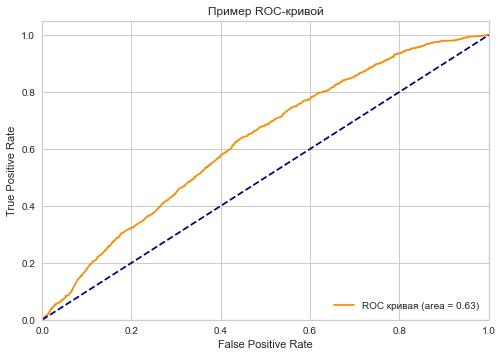

In [9]:
# получаем предказания
lr_probs_logreg = best_logreg.predict_proba(x_test)
# сохраняем вероятности только для положительного исхода
lr_probs_logreg = lr_probs_logreg[:, 1]
# рассчитываем ROC AUC
lr_auc = roc_auc_score(y_test, lr_probs_logreg)
print('LogisticRegression: ROC AUC=%.3f' % (lr_auc))
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(y_test, lr_probs_logreg)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Пример ROC-кривой')
plt.legend(loc="lower right")
plt.show()

## Random Forest

In [5]:
rf_clf = RandomForestClassifier(random_state=42) #помещаем модель случайного леса в переменную
rf_clf.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [11]:
predicted_train_rf = rf_clf.predict(x_train) #делаем предсказание модели случайного леса на тренировочных данных
predicted_test_rf = rf_clf.predict(x_test) #делаем предсказание случайного леса на тестовой выборке

print(accuracy_score(y_train, predicted_train_rf)) #проверяем как обучилась модель на тренировочных данных
print(accuracy_score(y_test, predicted_test_rf)) #проверяем как модель предсказывает целевую метрику на новых данных

0.9943339285714285
0.9944041666666666


### ROC-AUC Random Forest

RandomForest: ROC AUC=0.747


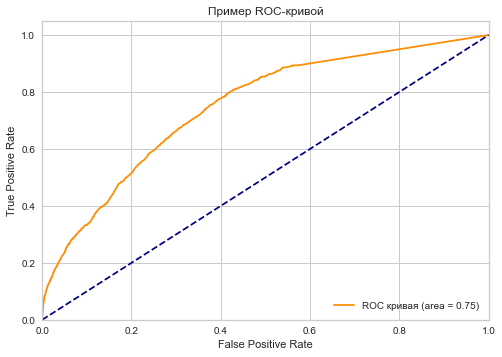

In [18]:
# получаем предказания
lr_probs_rf_clf = rf_clf.predict_proba(x_test)
# сохраняем вероятности только для положительного исхода
lr_probs_rf_clf = lr_probs_rf_clf[:, 1]
# рассчитываем ROC AUC
lr_auc = roc_auc_score(y_test, lr_probs_rf_clf)
print('RandomForest: ROC AUC=%.3f' % (lr_auc))
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(y_test, lr_probs_rf_clf)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Пример ROC-кривой')
plt.legend(loc="lower right")
plt.show()

## MLPClassifier

In [13]:
#инициализируем модель нейронной сети для задач классификации
mlp = MLPClassifier(random_state=42, max_iter=500, hidden_layer_sizes=(100,60,40,20))
mlp.fit(x_train, y_train) #обучаем нейронную сеть на тренировочной выборке

MLPClassifier(hidden_layer_sizes=(100, 60, 40, 20), max_iter=500,
              random_state=42)

In [14]:
pred_mlp = mlp.predict(x_test) #предсказываем данные с помощью обученной нейросети
accuracy_score(y_test, pred_mlp) #проверяем точность нейросети

0.9944

### ROC-AUC MLPClassifier

MLPClassifier: ROC AUC=0.727


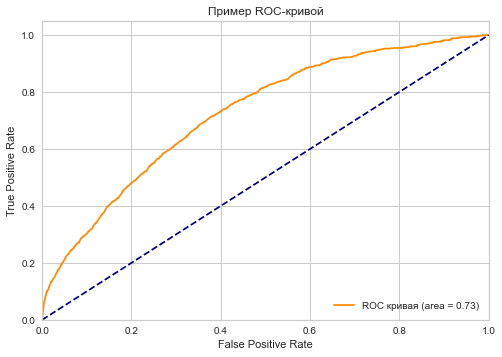

In [19]:
# получаем предказания
lr_probs_mlp = mlp.predict_proba(x_test)
# сохраняем вероятности только для положительного исхода
lr_probs_mlp = lr_probs_mlp[:, 1]
# рассчитываем ROC AUC
lr_auc = roc_auc_score(y_test, lr_probs_mlp)
print('MLPClassifier: ROC AUC=%.3f' % (lr_auc))
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(y_test, lr_probs_mlp)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Пример ROC-кривой')
plt.legend(loc="lower right")
plt.show()

## Кросс-валидация моделей

In [16]:
logreg_cross = cross_val_score(best_logreg, x, y, cv=4) #проводим кросс валидацию модели логистической регрессии
logreg_cross #выводим результат

array([0.994355, 0.99435 , 0.99435 , 0.99435 ])

In [11]:
rf_cross = cross_val_score(rf_clf, x, y, cv=4) #проводим кросс валидацию модели случайного леса и выводим результат
rf_cross

array([0.9948045 , 0.91197101, 0.92141219, 0.99480332])

In [6]:
mlp_cross = cross_val_score(mlp, x, y, cv=4) #проводим кросс валидацию модели многослойного перцептрона и выводим результат
mlp_cross

array([0.9948045 , 0.99480332, 0.99480332, 0.99480332])

In [ ]:
print(sum(logreg_cross), sum(rf_cross), sum(mlp_cross)) #выясняем, какая модель показала лучшие результаты на кросс-валидации
print(f'Лучшая модель: Random Forest')

In [7]:
#проверяем модель на данных, которые модель не видела
x = df_prepared_2.drop(['target'], axis=1)
y = df_prepared_2.target

best_predicted_test_rf = rf_clf.predict(x_test) 

print(accuracy_score(y_test, best_predicted_test_rf)) 

0.9944041666666666


## Shap

In [6]:
#присваеваем модель случайного леса переменной
model = rf_clf.fit(x_train, y_train)

In [7]:
#помещаем shap.Explainer в переменную 
explainer = shap.Explainer(model)

In [ ]:
#присваеваем переменную значениям отработанного explainer'a
shap_values = explainer(x_test)

In [ ]:
#визуализируем SHAP-значение для 1-го образца
shap.plots.waterfall(shap_values[:,:,1][1], max_display=40)

In [ ]:
shap.plots.force(shap_values[:,:,1][1])

In [ ]:
#визуализируем все SHAP‑значения для каждого признака.
shap.plots.beeswarm(shap_values[:,:,1], max_display=40)

In [ ]:
#результаты усреднения SHAP‑значений наиболее важных признаков для прогноза, по всем наблюдениям. 
shap.plots.bar(shap_values[:,:,1], max_display=30)

In [ ]:
shap.plots.scatter(shap_values[:,:,1][:,"utm_adcontent"])

## Results

In [83]:
filename = 'sber_rf_clf_model.pickle' #сериализуем лучшую модель в файл огурчика

with open(filename, 'wb') as file:

    pickle.dump(rf_clf, file) # rf_clf — наша модель